## Global Runoff Data Center streamflow data pre-processing

#### The main objective of this script is to perform a pre-processing analysis of the available streamflow data from the GRDC, having a close look at the countries, time-lengh availability and gaps.

Written by: Thiago Victor Medeiros do Nascimento

References:

1. Global Runoff Data Center: https://www.bafg.de/GRDC/EN/Home/homepage_node.html

First we import some useful modules:

In [1]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pymannkendall as mk
from plotly.offline import plot
import contextily as cx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
import datetime
import tqdm as tqdm
import os
import glob
warnings.simplefilter(action='ignore', category=Warning)


%config Completer.use_jedi = False # This improve the auto-fill function

In [2]:
import geospatialfunctions as geospatialfunctions

First we should set our directory:

In [3]:
path = r"C:\Users\nascimth\Documents\Thiago\Eawag\Python\Datasets"
os.chdir(path)
os.getcwd()

'C:\\Users\\nascimth\\Documents\\Thiago\\Eawag\\Python\\Datasets'

Here we can import the full GRDC network information:

In [4]:
network = pd.read_excel(r'GRDC\grdc_stations\GRDC_Stations.xlsx', skiprows=0)
network

grdc_no  wmo_reg  sub_reg                     river  \
0      1104150        1     1041               OUED CHELIF   
1      1104200        1     1041                 OUED MINA   
2      1104300        1     1041                OUED GHIOU   
3      1104450        1     1040             OUED MAZAFRAN   
4      1104480        1     1040           OUED BOU DOUAOU   
...        ...      ...      ...                       ...   
10699  6987100        6     6870                    SHAKHE   
10700  6987150        6     6870                     SOCHI   
10701  6998200        6     6984   KANGERLUARSUNNGUUP KUUA   
10702  6998300        6     6984                  KUUSSUAQ   
10703  6998400        6     6982  ZACKENBERG BAY TRIBUTARY   

                              station country        lat       long     area  \
0                        SIDI BELATAR      DZ  36.020000   0.270000  43750.0   
1                       OUED EL-ABTAL      DZ  35.500000   0.680000   6635.0   
2                         AMMI MOUSSA      DZ  35.870000   1.120000   2398.0   
3                        FER A CHEVAL      DZ  36.670000   2.820000   1912.0   
4                             KEDDARA      DZ  36.650000   3.420000    829.0   
...                               ...     ...        ...        ...      ...   
10699                       SOLOKHAUL      RU  43.799444  39.678056    423.0   
10700                       PLASTUNKA      RU  43.680556  39.822222    238.0   
10701  KOBBEFJORD HYDROMETRIC STATION      DK  64.133110 -51.380780     31.0   
10702                    QEQERTARSUAQ      DK  69.253620 -53.498230    100.0   
10703  ZACKENBERG HYDROMETRIC STATION      DK  74.470700 -20.576750    514.0   

       altitude  ...  m_start   m_end  m_yrs  m_miss  t_start  t_end  t_yrs  \
0           2.0  ...   1976.0  1977.0    2.0     0.0     1976   2001     26   
1         205.0  ...   1976.0  1978.0    3.0     0.0     1976   1978      3   
2         140.0  ...   1976.0  1979.0    4.0     0.0     1976   1979      4   
3          10.0  ...   1976.0  1978.0    3.0     0.0     1976   1995     20   
4          60.0  ...   1976.0  1979.0    4.0     0.0     1976   1979      4   
...         ...  ...      ...     ...    ...     ...      ...    ...    ...   
10699     133.0  ...   1978.0  1987.0   10.0     0.0     1978   1987     10   
10700    -999.0  ...   1978.0  1987.0   10.0     0.0     1978   1987     10   
10701      22.0  ...      NaN     NaN    NaN     NaN     2006   2020     15   
10702       7.0  ...      NaN     NaN    NaN     NaN     2015   2021      7   
10703      14.0  ...      NaN     NaN    NaN     NaN     1996   2020     25   

       lta_discharge  r_volume_yr  r_height_yr  
0             15.027     0.473891    10.831805  
1              2.578       0.0813    12.253174  
2              3.195     0.100758    42.017314  
3              3.379      0.10656    55.732293  
4              0.354     0.011164    13.466519  
...              ...          ...          ...  
10699         29.333     0.925045  2186.868766  
10700         15.585     0.491489  2065.077983  
10701          1.219     0.038442  1240.076903  
10702           n.a.         n.a.         n.a.  
10703          5.971     0.188301   366.345245  

[10704 rows x 24 columns]

Here we select only Europe (WMO = 6):

In [18]:
network_eu = network[network.wmo_reg == 6]
network_eu

grdc_no  wmo_reg  sub_reg                     river  \
7737   6111100        6     6111                  RIO MINO   
7738   6112070        6     6121                 RIO PAIVA   
7739   6112080        6     6121                RIO TAMEGA   
7740   6112090        6     6121                 RIO DOURO   
7741   6112100        6     6121                 RIO DOURO   
...        ...      ...      ...                       ...   
10699  6987100        6     6870                    SHAKHE   
10700  6987150        6     6870                     SOCHI   
10701  6998200        6     6984   KANGERLUARSUNNGUUP KUUA   
10702  6998300        6     6984                  KUUSSUAQ   
10703  6998400        6     6982  ZACKENBERG BAY TRIBUTARY   

                              station country        lat       long     area  \
7737                     FOZ DO MOURO      PT  42.077000  -8.391000  15407.2   
7738                     CASTRO DAIRE      PT  40.892000  -7.933000    288.3   
7739           PONTE CANAVEZES (R.E.)      PT  41.195000  -8.161000   3163.3   
7740                            RÉGUA      PT  41.154000  -7.782000  91505.6   
7741                          POCINHO      PT  41.159000  -7.114000  81293.9   
...                               ...     ...        ...        ...      ...   
10699                       SOLOKHAUL      RU  43.799444  39.678056    423.0   
10700                       PLASTUNKA      RU  43.680556  39.822222    238.0   
10701  KOBBEFJORD HYDROMETRIC STATION      DK  64.133110 -51.380780     31.0   
10702                    QEQERTARSUAQ      DK  69.253620 -53.498230    100.0   
10703  ZACKENBERG HYDROMETRIC STATION      DK  74.470700 -20.576750    514.0   

       altitude  ...  m_start   m_end  m_yrs  m_miss  t_start  t_end  t_yrs  \
7737       12.0  ...   1976.0  1984.0    9.0     0.0     1976   1989     14   
7738      459.0  ...   1976.0  1984.0    9.0     0.0     1972   1985     14   
7739       67.0  ...   1976.0  1984.0    9.0     0.0     1955   1987     33   
7740       67.0  ...   1933.0  1969.0   37.0     0.0     1933   1969     37   
7741      113.0  ...   1973.0  1975.0    3.0     0.0     1973   1975      3   
...         ...  ...      ...     ...    ...     ...      ...    ...    ...   
10699     133.0  ...   1978.0  1987.0   10.0     0.0     1978   1987     10   
10700    -999.0  ...   1978.0  1987.0   10.0     0.0     1978   1987     10   
10701      22.0  ...      NaN     NaN    NaN     NaN     2006   2020     15   
10702       7.0  ...      NaN     NaN    NaN     NaN     2015   2021      7   
10703      14.0  ...      NaN     NaN    NaN     NaN     1996   2020     25   

       lta_discharge  r_volume_yr  r_height_yr  
7737         343.465    10.831512   703.016268  
7738           6.997     0.220657   765.374235  
7739           70.98     2.238425   707.623457  
7740         542.042    17.093837   186.806452  
7741         314.262     9.910566   121.910333  
...              ...          ...          ...  
10699         29.333     0.925045  2186.868766  
10700         15.585     0.491489  2065.077983  
10701          1.219     0.038442  1240.076903  
10702           n.a.         n.a.         n.a.  
10703          5.971     0.188301   366.345245  

[2967 rows x 24 columns]

In [9]:
#Quick check of the columns' types:
network_eu.dtypes

grdc_no                   int64
wmo_reg                   int64
sub_reg                   int64
river                    object
station                  object
country                  object
lat                     float64
long                    float64
area                    float64
altitude                float64
d_start          datetime64[ns]
d_end            datetime64[ns]
d_yrs                   float64
d_miss                  float64
m_start                 float64
m_end                   float64
m_yrs                   float64
m_miss                  float64
t_start                   int64
t_end                     int64
t_yrs                     int64
lta_discharge            object
r_volume_yr              object
r_height_yr              object
dtype: object

In [20]:
# At this part it is important to convert our columns representing dates to datetime:
network_eu["d_start"] = pd.to_datetime(network_eu['d_start'], format='%Y')
network_eu["d_end"] = pd.to_datetime(network_eu['d_end'], format='%Y')       

network_eu

grdc_no  wmo_reg  sub_reg                     river  \
7737   6111100        6     6111                  RIO MINO   
7738   6112070        6     6121                 RIO PAIVA   
7739   6112080        6     6121                RIO TAMEGA   
7740   6112090        6     6121                 RIO DOURO   
7741   6112100        6     6121                 RIO DOURO   
...        ...      ...      ...                       ...   
10699  6987100        6     6870                    SHAKHE   
10700  6987150        6     6870                     SOCHI   
10701  6998200        6     6984   KANGERLUARSUNNGUUP KUUA   
10702  6998300        6     6984                  KUUSSUAQ   
10703  6998400        6     6982  ZACKENBERG BAY TRIBUTARY   

                              station country        lat       long     area  \
7737                     FOZ DO MOURO      PT  42.077000  -8.391000  15407.2   
7738                     CASTRO DAIRE      PT  40.892000  -7.933000    288.3   
7739           PONTE CANAVEZES (R.E.)      PT  41.195000  -8.161000   3163.3   
7740                            RÉGUA      PT  41.154000  -7.782000  91505.6   
7741                          POCINHO      PT  41.159000  -7.114000  81293.9   
...                               ...     ...        ...        ...      ...   
10699                       SOLOKHAUL      RU  43.799444  39.678056    423.0   
10700                       PLASTUNKA      RU  43.680556  39.822222    238.0   
10701  KOBBEFJORD HYDROMETRIC STATION      DK  64.133110 -51.380780     31.0   
10702                    QEQERTARSUAQ      DK  69.253620 -53.498230    100.0   
10703  ZACKENBERG HYDROMETRIC STATION      DK  74.470700 -20.576750    514.0   

       altitude  ... m_start   m_end  m_yrs  m_miss  t_start  t_end  t_yrs  \
7737       12.0  ...  1976.0  1984.0    9.0     0.0     1976   1989     14   
7738      459.0  ...  1976.0  1984.0    9.0     0.0     1972   1985     14   
7739       67.0  ...  1976.0  1984.0    9.0     0.0     1955   1987     33   
7740       67.0  ...  1933.0  1969.0   37.0     0.0     1933   1969     37   
7741      113.0  ...  1973.0  1975.0    3.0     0.0     1973   1975      3   
...         ...  ...     ...     ...    ...     ...      ...    ...    ...   
10699     133.0  ...  1978.0  1987.0   10.0     0.0     1978   1987     10   
10700    -999.0  ...  1978.0  1987.0   10.0     0.0     1978   1987     10   
10701      22.0  ...     NaN     NaN    NaN     NaN     2006   2020     15   
10702       7.0  ...     NaN     NaN    NaN     NaN     2015   2021      7   
10703      14.0  ...     NaN     NaN    NaN     NaN     1996   2020     25   

       lta_discharge  r_volume_yr  r_height_yr  
7737         343.465    10.831512   703.016268  
7738           6.997     0.220657   765.374235  
7739           70.98     2.238425   707.623457  
7740         542.042    17.093837   186.806452  
7741         314.262     9.910566   121.910333  
...              ...          ...          ...  
10699         29.333     0.925045  2186.868766  
10700         15.585     0.491489  2065.077983  
10701          1.219     0.038442  1240.076903  
10702           n.a.         n.a.         n.a.  
10703          5.971     0.188301   366.345245  

[2967 rows x 24 columns]

Here we can plot our dataset using one of the geospatialfunctions function:

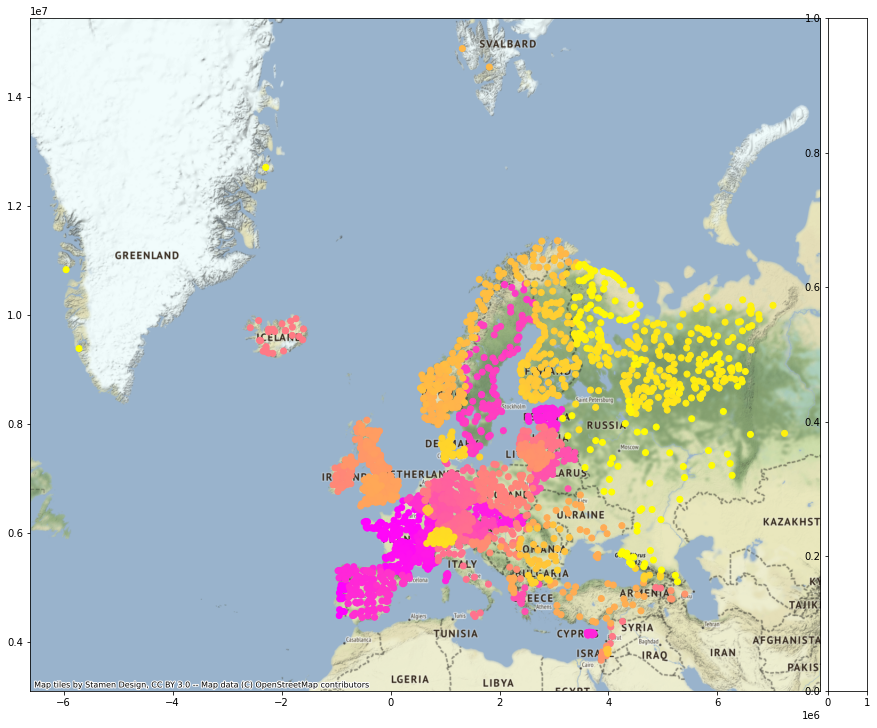

In [91]:
coords = network_eu[["long", "lat", "grdc_no"]]
coords.set_index('grdc_no', inplace = True)
coords.astype(float)

geospatialfunctions.plotpoints(coords)

Here we can check all the country' symbols within our dataset:

In [35]:
countries = network_eu["country"].unique().tolist()
countries

['PT',
 'FR',
 'CZ',
 'SK',
 'EE',
 'CY',
 'ES',
 'BE',
 'SE',
 'AT',
 'BY',
 'GR',
 'DE',
 'IT',
 'LV',
 'AM',
 'SY',
 'IS',
 'NL',
 'HU',
 'PL',
 'IE',
 'RS',
 'SI',
 'BA',
 'MK',
 'LT',
 'AZ',
 'IL',
 'GB',
 'UA',
 'HR',
 'AL',
 'TR',
 'NO',
 'RO',
 'MD',
 'JO',
 'FI',
 'LU',
 'BG',
 'GE',
 'RU',
 'DK',
 'CH']

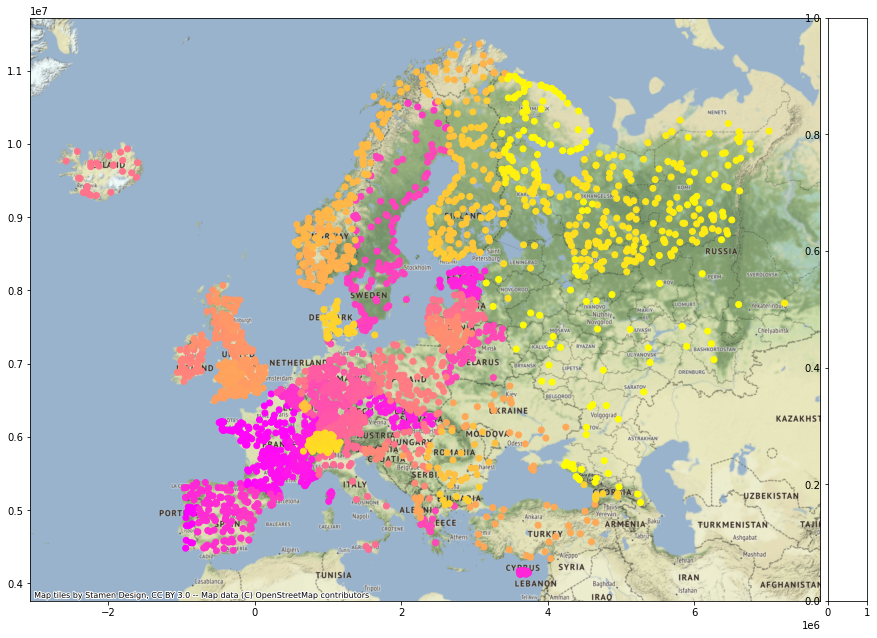

In [93]:
#This list takes only countries within Europe:
countries_used = ['PT', 'FR', 'CZ', 'SK', 'EE', 'CY', 'ES', 'BE', 'SE', 'BY', 'GR', 'DE', 'IT', 'LV', 
                  'IS', 'NL', 'HU', 'PL', 'IE', 'RS', 'SI', 'BA', 'MK', 'LT', 'GB', 'UA', 'HR', 'AL', 
                  'TR', 'NO', 'RO', 'MD', 'FI', 'LU', 'BG', 'GE', 'RU', 'DK', 'CH']

network_eu_2 = network_eu.loc[network_eu.apply(lambda x: x.country in countries_used, axis=1)]


# We can also take out some domains from Denmark and Norway:
stations_out = [6998300, 6998200, 6998400, 6730710, 6730700]

for station in stations_out:
    network_eu_2.drop(network_eu_2[network_eu_2['grdc_no'] == station].index, inplace = True)

# Finally we can plot our available data:
coords = network_eu_2[["long", "lat", "grdc_no"]]
coords.set_index('grdc_no', inplace = True)
geospatialfunctions.plotpoints(coords)

##### We chose to keep the countries which we have official information from their respective websites or published databases such as CAMELS, but we will give priority for the last prior to the GRDC.

2. Conditional filters:

At this part we can start with some conditional filters in order to select only datasets with potential usable data based on their reported start and end dates.

In [94]:
network_cond_1 = network_eu_2[network_eu_2.d_start < "1995"]
network_cond_1

grdc_no  wmo_reg  sub_reg                  river  \
7737   6111100        6     6111               RIO MINO   
7738   6112070        6     6121              RIO PAIVA   
7739   6112080        6     6121             RIO TAMEGA   
7742   6113050        6     6131            TAGUS RIVER   
7746   6114150        6     6140              RIO VOUGA   
...        ...      ...      ...                    ...   
10695  6984700        6     6841  KAZIKUMUKHSKOYE KOYSU   
10696  6984800        6     6841             KARA-SAMUR   
10698  6987050        6     6870              PSEZUAPSE   
10699  6987100        6     6870                 SHAKHE   
10700  6987150        6     6870                  SOCHI   

                      station country        lat       long     area  \
7737             FOZ DO MOURO      PT  42.077000  -8.391000  15407.2   
7738             CASTRO DAIRE      PT  40.892000  -7.933000    288.3   
7739   PONTE CANAVEZES (R.E.)      PT  41.195000  -8.161000   3163.3   
7742                 ALMOUROL      PT  39.461000  -8.375000  67482.3   
7746            PONTE VOUZELA      PT  40.733000  -8.112000    648.8   
...                       ...     ...        ...        ...      ...   
10695              GUERGUEBIL      RU  42.386667  46.960556   1850.0   
10696                  LUCHEK      RU  41.611667  47.307222    481.0   
10698             TAT'YANOVKA      RU  43.959167  39.409167    255.0   
10699               SOLOKHAUL      RU  43.799444  39.678056    423.0   
10700               PLASTUNKA      RU  43.680556  39.822222    238.0   

       altitude  ... m_start   m_end  m_yrs     m_miss  t_start  t_end  t_yrs  \
7737       12.0  ...  1976.0  1984.0    9.0   0.000000     1976   1989     14   
7738      459.0  ...  1976.0  1984.0    9.0   0.000000     1972   1985     14   
7739       67.0  ...  1976.0  1984.0    9.0   0.000000     1955   1987     33   
7742       19.0  ...  1973.0  1990.0   18.0   5.882353     1973   1990     18   
7746      159.0  ...  1980.0  1984.0    5.0   3.333333     1980   1990     11   
...         ...  ...     ...     ...    ...        ...      ...    ...    ...   
10695     655.0  ...  1978.0  1987.0   10.0  10.000000     1978   1987     10   
10696    1436.0  ...  1965.0  1984.0   20.0   0.000000     1965   1987     23   
10698    -999.0  ...  1978.0  1987.0   10.0   0.000000     1978   1987     10   
10699     133.0  ...  1978.0  1987.0   10.0   0.000000     1978   1987     10   
10700    -999.0  ...  1978.0  1987.0   10.0   0.000000     1978   1987     10   

       lta_discharge  r_volume_yr  r_height_yr  
7737         343.465    10.831512   703.016268  
7738           6.997     0.220657   765.374235  
7739           70.98     2.238425   707.623457  
7742         342.692    10.807135   160.147697  
7746          13.017     0.410504   632.712873  
...              ...          ...          ...  
10695         13.449     0.424128   229.258197  
10696          8.784     0.277012    575.90899  
10698         13.962     0.440306  1726.688753  
10699         29.333     0.925045  2186.868766  
10700         15.585     0.491489  2065.077983  

[2364 rows x 24 columns]

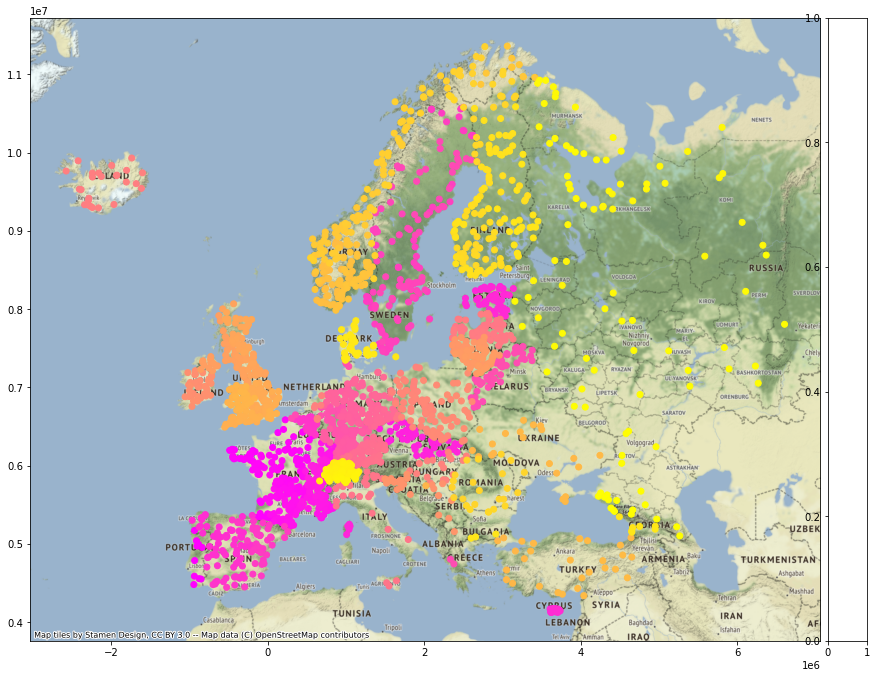

In [95]:
# Finally we can plot our available data:
coords = network_cond_1[["long", "lat", "grdc_no"]]
coords.set_index('grdc_no', inplace = True)
geospatialfunctions.plotpoints(coords)

In [96]:
network_cond_2 = network_cond_1[network_cond_1.d_end > "2000"]
network_cond_2

grdc_no  wmo_reg  sub_reg        river                station country  \
7753   6118130        6     6180  ABER VRAC'H                DRENNEC      FR   
7754   6118150        6     6180      GUILLEC              TREZILIDE      FR   
7755   6118160        6     6180        PENZE        TAULE (PENHOAT)      FR   
7756   6118165        6     6180        RISLE                    RAI      FR   
7757   6118175        6     6180       JARLOT             PLOUGONVEN      FR   
...        ...      ...      ...          ...                    ...     ...   
10607  6971130        6     6712       TULOMA  VERKHNE-TULOMSKIY GES      RU   
10643  6971600        6     6713      VARZUGA                VARZUGA      RU   
10673  6977100        6     6771        VOLGA  VOLGOGRAD POWER PLANT      RU   
10676  6978250        6     6781          DON            RAZDORSKAYA      RU   
10685  6983350        6     6831       KUBAN'              TIKHOVSKY      RU   

             lat       long       area  altitude  ... m_start   m_end  m_yrs  \
7753   48.530410  -4.362693       24.0     90.60  ...     NaN     NaN    NaN   
7754   48.615037  -4.077011       43.0     91.10  ...     NaN     NaN    NaN   
7755   48.584822  -3.924127      141.0     61.97  ...     NaN     NaN    NaN   
7756   48.747942   0.580580      149.0    255.45  ...     NaN     NaN    NaN   
7757   48.565562  -3.800485       44.0     73.86  ...     NaN     NaN    NaN   
...          ...        ...        ...       ...  ...     ...     ...    ...   
10607  68.600000  31.750000    17500.0   -999.00  ...  1934.0  2017.0   84.0   
10643  66.400000  36.300000     7940.0      9.00  ...  1935.0  1992.0   58.0   
10673  48.804722  44.585833  1360000.0   -999.00  ...  1879.0  1984.0  106.0   
10676  47.540833  40.647222   378000.0     58.00  ...  1881.0  1984.0  104.0   
10685  45.191111  38.229167    48100.0      5.00  ...  1911.0  1985.0   75.0   

          m_miss  t_start  t_end  t_yrs  lta_discharge  r_volume_yr  \
7753         NaN     1966   2012     47          0.448     0.014128   
7754         NaN     1966   2012     47          0.682     0.021508   
7755         NaN     1967   2012     46          2.813     0.088711   
7756         NaN     1965   2012     48          1.379     0.043488   
7757         NaN     1966   2012     47          0.712     0.022454   
...          ...      ...    ...    ...            ...          ...   
10607  25.349301     1934   2017     84        193.903     6.114925   
10643   0.288600     1935   2011     77          91.75     2.893428   
10673  17.924528     1879   2010    132       7827.676    246.85359   
10676   3.453815     1881   2010    130        681.961    21.506322   
10685  25.531915     1911   2002     92        369.252    11.644731   

       r_height_yr  
7753       588.672  
7754    500.175628  
7755    629.154383  
7756    291.866738  
7757    510.309818  
...            ...  
10607   349.424286  
10643   364.411587  
10673   181.509993  
10676    56.895032  
10685   242.094201  

[1823 rows x 24 columns]

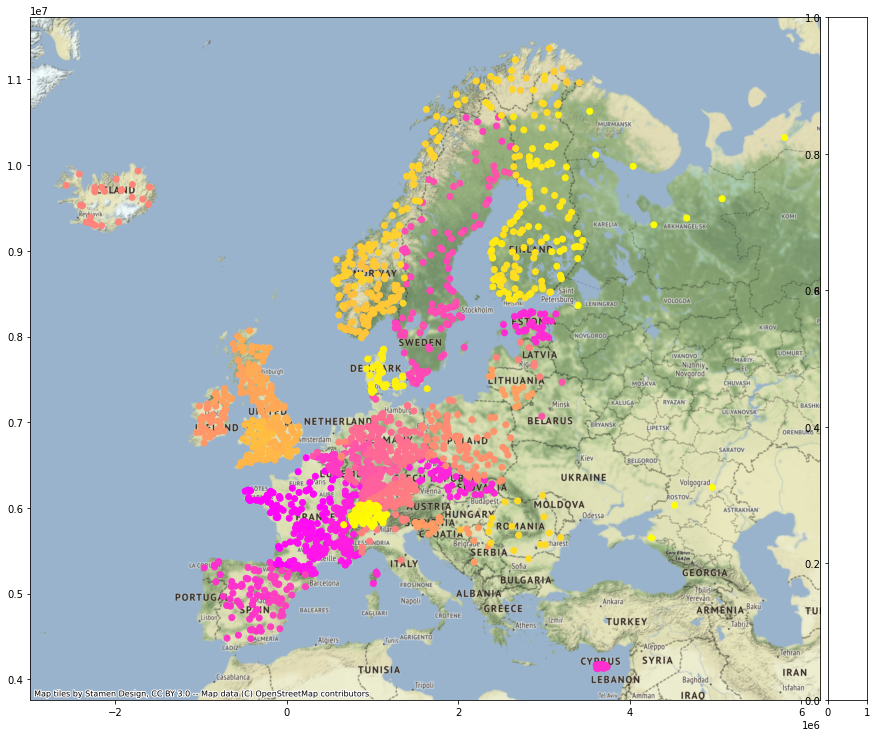

In [97]:
coords = network_cond_2[["long", "lat", "grdc_no"]]
coords.set_index('grdc_no', inplace = True)

geospatialfunctions.plotpoints(coords)

Here we can provide a quick overlook at the last and first year of daily streamflow data availability:

<AxesSubplot:title={'center':'Last year of available daily data'}>

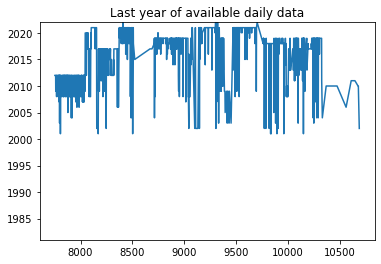

In [109]:
network_cond_2.d_end.plot(title = "Last year of available daily data", 
                          ylim = [datetime.date(1981, 1, 1), datetime.date(2022, 1, 1)])

<AxesSubplot:title={'center':'First year of available daily data'}>

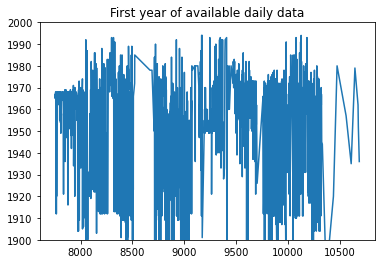

In [113]:
network_cond_2.d_start.plot(title = "First year of available daily data", 
                            ylim = [datetime.date(1900, 1, 1), datetime.date(2000, 1, 1)])

Here we can have a small check analysing data for a specific country:

In [32]:
network_DE = network_cond_2[network_cond_2.country == "DE"]
network_DE

grdc_no  wmo_reg  sub_reg                  river         station  \
8709  6321100        6     6211                  NIERS            GOCH   
8710  6321200        6     6211                   ROER            STAH   
8711  6334270        6     6340            SOHOLMER AU          SOHOLM   
8712  6334280        6     6340              LECKER AU  LECK-KARLSMARK   
8713  6334800        6     6340                 TREENE           TREIA   
...       ...      ...      ...                    ...             ...   
9065  6357501        6     6571  LUSATIAN NEISSE RIVER         GUBEN 2   
9066  6357502        6     6571  LUSATIAN NEISSE RIVER        GOERLITZ   
9067  6357503        6     6571  LUSATIAN NEISSE RIVER          HARTAU   
9069  6357510        6     6571             PLIESSNITZ       TAUCHRITZ   
9070  6357520        6     6571                 MANDAU        ZITTAU 5   

     country        lat       long    area  altitude  ... m_start m_end  \
8709      DE  51.684000   6.151000  1203.0     12.02  ...     NaN   NaN   
8710      DE  51.097604   6.104184  2105.0     32.45  ...     NaN   NaN   
8711      DE  54.699745   9.022802   352.0      1.70  ...     NaN   NaN   
8712      DE  54.770658   8.976074   134.0      2.31  ...     NaN   NaN   
8713      DE  54.514342   9.317255   481.0      5.00  ...     NaN   NaN   
...      ...        ...        ...     ...       ...  ...     ...   ...   
9065      DE  51.969270  14.706722  4080.0     37.48  ...     NaN   NaN   
9066      DE  51.161160  14.993192  1621.0    175.63  ...     NaN   NaN   
9067      DE  50.872211  14.821047   376.0    233.14  ...     NaN   NaN   
9069      DE  51.064069  14.944133   162.0    197.20  ...     NaN   NaN   
9070      DE  50.891976  14.802623  -999.0   -999.00  ...     NaN   NaN   

      m_yrs  m_miss  t_start  t_end  t_yrs  lta_discharge  r_volume_yr  \
8709    NaN     NaN     1950   2018     69           7.74     0.244089   
8710    NaN     NaN     1960   2018     59         21.534     0.679096   
8711    NaN     NaN     1984   2019     36           4.85      0.15295   
8712    NaN     NaN     1984   2004     21          1.877     0.059193   
8713    NaN     NaN     1931   2019     89          6.453     0.203502   
...     ...     ...      ...    ...    ...            ...          ...   
9065    NaN     NaN     1959   2019     61         28.432     0.896632   
9066    NaN     NaN     1912   2019    108         16.879     0.532296   
9067    NaN     NaN     1957   2016     60          5.849     0.184454   
9069    NaN     NaN     1964   2019     56          1.096     0.034563   
9070    NaN     NaN     1912   2015    104          3.031     0.095586   

      r_height_yr  
8709    202.89995  
8710   322.611033  
8711   434.515909  
8712   441.739343  
8713   423.080682  
...           ...  
9065   219.762635  
9066   328.375166  
9067   490.569319  
9069   213.354667  
9070         n.a.  

[320 rows x 24 columns]

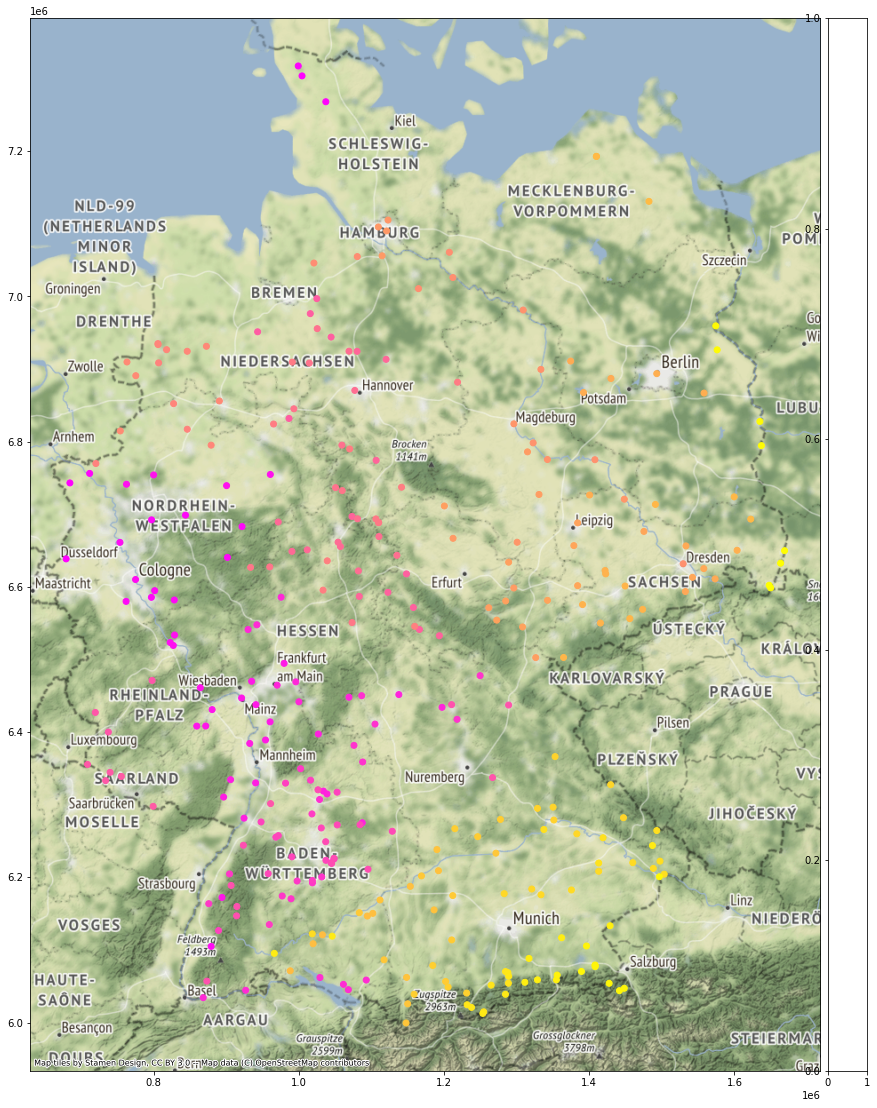

In [98]:
coords = network_DE[["long", "lat", "grdc_no"]]
coords.set_index('grdc_no', inplace = True)

geospatialfunctions.plotpoints(coords)

<AxesSubplot:title={'center':'Last year of available daily data'}>

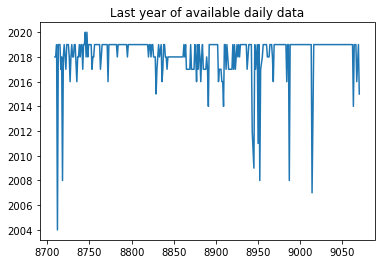

In [114]:
network_DE.d_end.plot(title = "Last year of available daily data")

<AxesSubplot:title={'center':'First year of available daily data'}>

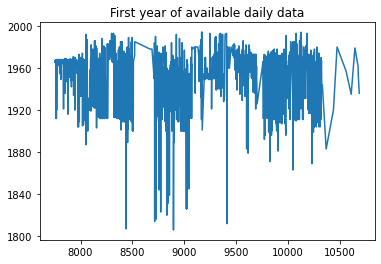

In [115]:
network_cond_2.d_start.plot(title = "First year of available daily data")

With this, we can use the stations called network_cond_2 as the ones to build our time-series data frames with.

3. Full time-series organization:

At this part we can organize the time-series in a single dataframe where each column will represent a different station, and each row a different date.

In [119]:
# First we can check our files within the folder:
path =r'GRDC\original'
filenames = glob.glob(path + "/*.txt")
len(filenames)

2967

Here we can use a for loop to retrieve each station, organize which information is needed, an concatenate everything together:

In [194]:
i = 0
timeseriesfinal = pd.DataFrame(index = pd.date_range('09-01-1900','09-30-2022', freq='D'))

#### The tqdm module is useful for checking the progress bar of the loop.
for filename in tqdm.tqdm(filenames):
    # First we read our time-series:
    data = pd.read_csv(filename, encoding='latin-1', engine='python', skiprows = 36, delimiter = ";", usecols = [0, 2])

    # We define new column names:
    names = ['dates', 'Qm3s']
    data.columns = names

    # Convert our column of dates to datetime format:
    data["dates"] = pd.to_datetime(data["dates"], format='%Y-%m-%d')

    # We can replace the -999.0 to np.nan:
    data.Qm3s.replace(-999.0, np.nan, inplace=True)

    # Here we can set the index as the dates column:
    data.set_index("dates", inplace = True)

    # First we can retrieve the station name:
    namestation = os.path.basename(filename)
    namestation = namestation.split("_", 1)[0]
    
    timeseriesfinal.loc[:, int(namestation)] = data.Qm3s

100%|██████████████████████████████████████████████████████████████████████████████| 2967/2967 [03:29<00:00, 14.16it/s]


In [195]:
timeseriesfinal

6111100  6112070  6112080 6112090 6112100  6113050 6113100  \
1900-09-01      NaN      NaN      NaN     NaN     NaN      NaN     NaN   
1900-09-02      NaN      NaN      NaN     NaN     NaN      NaN     NaN   
1900-09-03      NaN      NaN      NaN     NaN     NaN      NaN     NaN   
1900-09-04      NaN      NaN      NaN     NaN     NaN      NaN     NaN   
1900-09-05      NaN      NaN      NaN     NaN     NaN      NaN     NaN   
...             ...      ...      ...     ...     ...      ...     ...   
2022-09-26      NaN      NaN      NaN     NaN     NaN      NaN     NaN   
2022-09-27      NaN      NaN      NaN     NaN     NaN      NaN     NaN   
2022-09-28      NaN      NaN      NaN     NaN     NaN      NaN     NaN   
2022-09-29      NaN      NaN      NaN     NaN     NaN      NaN     NaN   
2022-09-30      NaN      NaN      NaN     NaN     NaN      NaN     NaN   

           6113110 6114100  6114150  ... 6984500  6984700  6984800  6986100  \
1900-09-01     NaN     NaN      NaN  ...     NaN      NaN      NaN      NaN   
1900-09-02     NaN     NaN      NaN  ...     NaN      NaN      NaN      NaN   
1900-09-03     NaN     NaN      NaN  ...     NaN      NaN      NaN      NaN   
1900-09-04     NaN     NaN      NaN  ...     NaN      NaN      NaN      NaN   
1900-09-05     NaN     NaN      NaN  ...     NaN      NaN      NaN      NaN   
...            ...     ...      ...  ...     ...      ...      ...      ...   
2022-09-26     NaN     NaN      NaN  ...     NaN      NaN      NaN      NaN   
2022-09-27     NaN     NaN      NaN  ...     NaN      NaN      NaN      NaN   
2022-09-28     NaN     NaN      NaN  ...     NaN      NaN      NaN      NaN   
2022-09-29     NaN     NaN      NaN  ...     NaN      NaN      NaN      NaN   
2022-09-30     NaN     NaN      NaN  ...     NaN      NaN      NaN      NaN   

            6987050  6987100  6987150  6998200  6998300  6998400  
1900-09-01      NaN      NaN      NaN      NaN      NaN      NaN  
1900-09-02      NaN      NaN      NaN      NaN      NaN      NaN  
1900-09-03      NaN      NaN      NaN      NaN      NaN      NaN  
1900-09-04      NaN      NaN      NaN      NaN      NaN      NaN  
1900-09-05      NaN      NaN      NaN      NaN      NaN      NaN  
...             ...      ...      ...      ...      ...      ...  
2022-09-26      NaN      NaN      NaN      NaN      NaN      NaN  
2022-09-27      NaN      NaN      NaN      NaN      NaN      NaN  
2022-09-28      NaN      NaN      NaN      NaN      NaN      NaN  
2022-09-29      NaN      NaN      NaN      NaN      NaN      NaN  
2022-09-30      NaN      NaN      NaN      NaN      NaN      NaN  

[44590 rows x 2967 columns]

4. Gaps check:

At this part we can check for gaps in our time-series:

In [196]:
# Fist we check the stations used:
network_cond_2

grdc_no  wmo_reg  sub_reg        river                station country  \
7753   6118130        6     6180  ABER VRAC'H                DRENNEC      FR   
7754   6118150        6     6180      GUILLEC              TREZILIDE      FR   
7755   6118160        6     6180        PENZE        TAULE (PENHOAT)      FR   
7756   6118165        6     6180        RISLE                    RAI      FR   
7757   6118175        6     6180       JARLOT             PLOUGONVEN      FR   
...        ...      ...      ...          ...                    ...     ...   
10607  6971130        6     6712       TULOMA  VERKHNE-TULOMSKIY GES      RU   
10643  6971600        6     6713      VARZUGA                VARZUGA      RU   
10673  6977100        6     6771        VOLGA  VOLGOGRAD POWER PLANT      RU   
10676  6978250        6     6781          DON            RAZDORSKAYA      RU   
10685  6983350        6     6831       KUBAN'              TIKHOVSKY      RU   

             lat       long       area  altitude  ... m_start   m_end  m_yrs  \
7753   48.530410  -4.362693       24.0     90.60  ...     NaN     NaN    NaN   
7754   48.615037  -4.077011       43.0     91.10  ...     NaN     NaN    NaN   
7755   48.584822  -3.924127      141.0     61.97  ...     NaN     NaN    NaN   
7756   48.747942   0.580580      149.0    255.45  ...     NaN     NaN    NaN   
7757   48.565562  -3.800485       44.0     73.86  ...     NaN     NaN    NaN   
...          ...        ...        ...       ...  ...     ...     ...    ...   
10607  68.600000  31.750000    17500.0   -999.00  ...  1934.0  2017.0   84.0   
10643  66.400000  36.300000     7940.0      9.00  ...  1935.0  1992.0   58.0   
10673  48.804722  44.585833  1360000.0   -999.00  ...  1879.0  1984.0  106.0   
10676  47.540833  40.647222   378000.0     58.00  ...  1881.0  1984.0  104.0   
10685  45.191111  38.229167    48100.0      5.00  ...  1911.0  1985.0   75.0   

          m_miss  t_start  t_end  t_yrs  lta_discharge  r_volume_yr  \
7753         NaN     1966   2012     47          0.448     0.014128   
7754         NaN     1966   2012     47          0.682     0.021508   
7755         NaN     1967   2012     46          2.813     0.088711   
7756         NaN     1965   2012     48          1.379     0.043488   
7757         NaN     1966   2012     47          0.712     0.022454   
...          ...      ...    ...    ...            ...          ...   
10607  25.349301     1934   2017     84        193.903     6.114925   
10643   0.288600     1935   2011     77          91.75     2.893428   
10673  17.924528     1879   2010    132       7827.676    246.85359   
10676   3.453815     1881   2010    130        681.961    21.506322   
10685  25.531915     1911   2002     92        369.252    11.644731   

       r_height_yr  
7753       588.672  
7754    500.175628  
7755    629.154383  
7756    291.866738  
7757    510.309818  
...            ...  
10607   349.424286  
10643   364.411587  
10673   181.509993  
10676    56.895032  
10685   242.094201  

[1823 rows x 24 columns]

In [197]:
# Here we can create a list with the stations names:
stations_used = network_cond_2.grdc_no.tolist()

In [199]:
# Finally we create a time-series with only the stations used:
timeseriesfinal_used = timeseriesfinal.loc[:, stations_used]
timeseriesfinal_used

6118130  6118150  6118160  6118165  6118175  6118185  6118195  \
1900-09-01      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1900-09-02      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1900-09-03      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1900-09-04      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1900-09-05      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
...             ...      ...      ...      ...      ...      ...      ...   
2022-09-26      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2022-09-27      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2022-09-28      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2022-09-29      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2022-09-30      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

            6118205  6118230  6119010  ...  6970100  6970250  6970500  \
1900-09-01      NaN      NaN      NaN  ...      NaN      NaN      NaN   
1900-09-02      NaN      NaN      NaN  ...      NaN      NaN      NaN   
1900-09-03      NaN      NaN      NaN  ...      NaN      NaN      NaN   
1900-09-04      NaN      NaN      NaN  ...      NaN      NaN      NaN   
1900-09-05      NaN      NaN      NaN  ...      NaN      NaN      NaN   
...             ...      ...      ...  ...      ...      ...      ...   
2022-09-26      NaN      NaN      NaN  ...      NaN      NaN      NaN   
2022-09-27      NaN      NaN      NaN  ...      NaN      NaN      NaN   
2022-09-28      NaN      NaN      NaN  ...      NaN      NaN      NaN   
2022-09-29      NaN      NaN      NaN  ...      NaN      NaN      NaN   
2022-09-30      NaN      NaN      NaN  ...      NaN      NaN      NaN   

            6970700  6970869  6971130  6971600  6977100  6978250  6983350  
1900-09-01      NaN      NaN      NaN      NaN      NaN      NaN      NaN  
1900-09-02      NaN      NaN      NaN      NaN      NaN      NaN      NaN  
1900-09-03      NaN      NaN      NaN      NaN      NaN      NaN      NaN  
1900-09-04      NaN      NaN      NaN      NaN      NaN      NaN      NaN  
1900-09-05      NaN      NaN      NaN      NaN      NaN      NaN      NaN  
...             ...      ...      ...      ...      ...      ...      ...  
2022-09-26      NaN      NaN      NaN      NaN      NaN      NaN      NaN  
2022-09-27      NaN      NaN      NaN      NaN      NaN      NaN      NaN  
2022-09-28      NaN      NaN      NaN      NaN      NaN      NaN      NaN  
2022-09-29      NaN      NaN      NaN      NaN      NaN      NaN      NaN  
2022-09-30      NaN      NaN      NaN      NaN      NaN      NaN      NaN  

[44590 rows x 1823 columns]

In [200]:
# This auxiliar dataframe is used to better plot our dataset:
coords = network_cond_2[["long", "lat", "grdc_no"]]
coords.set_index('grdc_no', inplace = True)
coords

long        lat
grdc_no                      
6118130  -4.362693  48.530410
6118150  -4.077011  48.615037
6118160  -3.924127  48.584822
6118165   0.580580  48.747942
6118175  -3.800485  48.565562
...            ...        ...
6971130  31.750000  68.600000
6971600  36.300000  66.400000
6977100  44.585833  48.804722
6978250  40.647222  47.540833
6983350  38.229167  45.191111

[1823 rows x 2 columns]

In [201]:
summarygapsstations = geospatialfunctions.summarygaps(timeseriesfinal_used.loc["1971":"2018",:], coords)
summarygapsstations

CoordX     CoordY  NumGaps  PercentageGaps
Code                                                  
6118130  -4.362693  48.530410   2412.0       13.757700
6118150  -4.077011  48.615037   2740.0       15.628565
6118160  -3.924127  48.584822   2408.0       13.734885
6118165   0.580580  48.747942   3486.0       19.883641
6118175  -3.800485  48.565562   2578.0       14.704540
...            ...        ...      ...             ...
6971130  31.750000  68.600000   2923.0       16.672371
6971600  36.300000  66.400000   5844.0       33.333333
6977100  44.585833  48.804722   3287.0       18.748574
6978250  40.647222  47.540833   3654.0       20.841889
6983350  38.229167  45.191111   8036.0       45.836185

[1823 rows x 4 columns]

<AxesSubplot:xlabel='Code'>

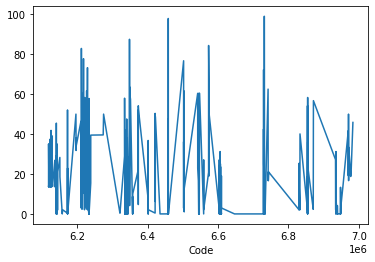

In [202]:
summarygapsstations.PercentageGaps.plot()

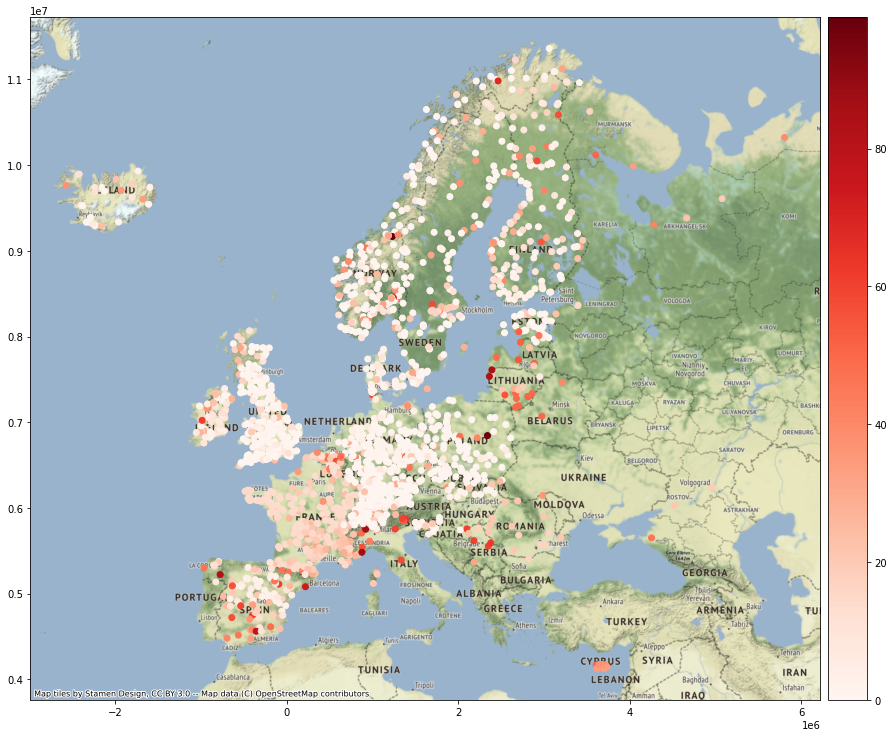

In [203]:
geospatialfunctions.plotgaps(summarygapsstations = summarygapsstations, crsproj = 'epsg:4326', backmapproj = True, 
                             figsizeproj = (15, 30), cmapproj = "Reds")

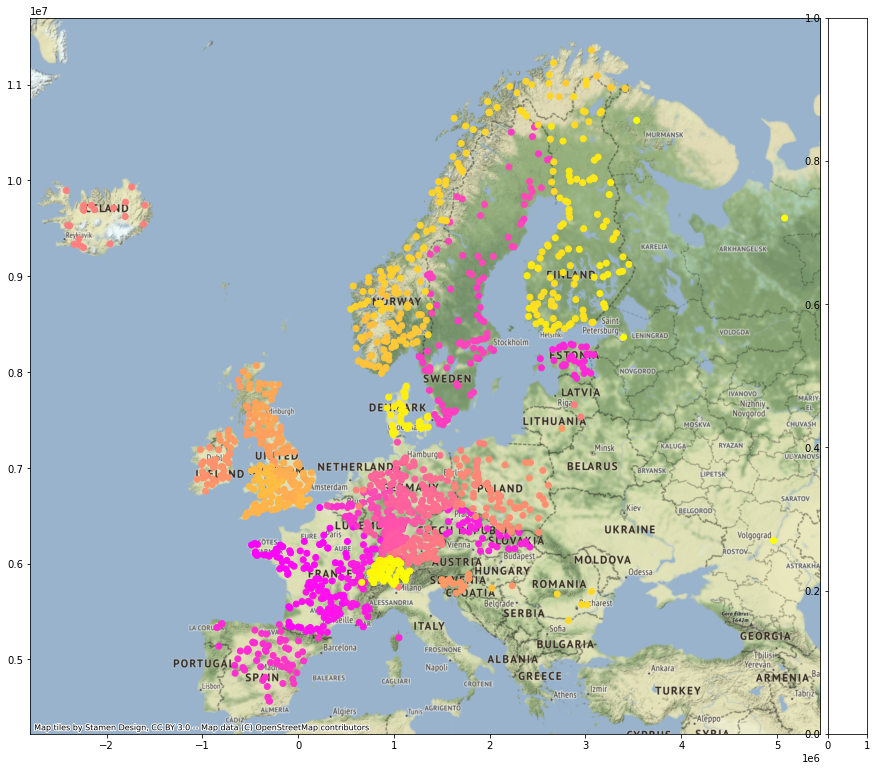

In [204]:
geospatialfunctions.plotpoints(summarygapsstations[summarygapsstations.PercentageGaps < 20.0], showcodes = False)